# apartment-hunter

The dataset is a home (in the King County area, Washington State) sales data that comes from the official public records. The data set contains 21613 rows. Each represents a home sold from May 2014 through May 2015.

#### Libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#from appartment_hunter import *  # Moved this code below to the "Functions" section to agree with exercise requirements

#### Functions

###### Calculating boxplot whiskers

We use a modified box plot where the whiskers extend from the the box to the adjacent values. The adjacent values are defined as the lowest and highest observations that are still inside the region defined by the following limits:  
$$ Q1 - 1.5 \times \text{IQR} $$  
  
$$ Q3 + 1.5 \times \text{IQR} $$  
  
$$ \text{IQR (Interquartile range)} = Q3 - Q1 $$

$ \text{Q1 (First Quartile)} $: value that separates the lowest 25% of the data from the remaining 75%. Mathematically, it's the median of the lower half of the dataset (calculating from the median of the dataset).  

$ \text{Q3 (Third Quartile)} $: value that separates the lowest 75% of the data from the highest 25%. Mathematically, it's the median of the upper half of the dataset.  
  
  
Function for calculating the upper and lower whisker limits are defined as upper_whisker(data):

In [2]:
def boxplot_whiskers(data):
    Q3 = data.quantile(0.75)
    Q1 = data.quantile(0.25)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    if lower_bound < 0:
        lower_bound = data.min()
    return lower_bound, upper_bound

def boxplot_whiskers_iterative_outliers_removal(dataframe, column_name):
    # 1. Creating a df `data_no_outliers` with initial removal of outliers
    dataframe = dataframe.copy()
    column = column_name
    data_whiskers = boxplot_whiskers(dataframe[column])
    data_no_outliers = dataframe[(dataframe[column] >= data_whiskers[0]) & (dataframe[column] <= data_whiskers[1])]

    # 2. Calculating the whisker bounds in the trimmed df `data_no_outliers`
    sqm_living_no_outliers_whiskers = boxplot_whiskers(data_no_outliers[column])

    # 3. Reiterating the removal of outliers until the whisker bounds remain constant
    previous_whiskers = sqm_living_no_outliers_whiskers
    while True:
        data_no_outliers = data_no_outliers[(data_no_outliers[column] >= boxplot_whiskers(data_no_outliers[column])[0]) & (data_no_outliers[column] <= boxplot_whiskers(data_no_outliers[column])[1])]
        current_whiskers = boxplot_whiskers(data_no_outliers[column])
        if previous_whiskers == current_whiskers:
            break
        previous_whiskers = current_whiskers
    return current_whiskers

###### Some visualization functions for quick view

In [3]:
def boxplot(data, label, title='', axis='y', figsize=(6,6)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=data) if axis == 'x' else sns.boxplot(y=data)
    if title != '':
        title = f'{title} '
    title = f'{title}Boxplot of {label}'
    plt.title(title)
    plt.xlabel(label) if axis == 'x' else plt.ylabel(label)
    plt.ticklabel_format(style='plain', axis=axis)
    plt.show()

def boxplot_categories(dataframe, column_name_x_axis, column_name_y_axis, figsize=(6, 6), xticksrotation=0, order_by_median_flag=False, title=None):
    if order_by_median_flag == False:
        pass
    else:
        try:
            median = dataframe.groupby(column_name_x_axis)[column_name_y_axis].median().sort_values()
        except:
            median = dataframe.groupby(column_name_y_axis)[column_name_x_axis].median().sort_values()
        ordered = median.index
    plt.figure(figsize=figsize)
    if order_by_median_flag == False:
        sns.boxplot(x=column_name_x_axis, y=column_name_y_axis, data=dataframe)
    else:
        sns.boxplot(x=column_name_x_axis, y=column_name_y_axis, data=dataframe, order=ordered)
    if title == None:
        plt.title(f'Box Plot of {column_name_y_axis} by {column_name_x_axis}')
    else:
        plt.title(title)
    plt.xlabel(column_name_x_axis)
    plt.xticks(rotation=xticksrotation)
    plt.ylabel(column_name_y_axis)
    if column_name_y_axis == 'price':
        plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
    elif column_name_x_axis == 'price':
        plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
    plt.grid(True)
    plt.show()

def histogram(data, bins, label, title='', figsize=(8, 6), xticksrotation=0, skewness=(0, 0), kurtosis=(0, 0), mean=False, median=False, legend=False):
    plt.figure(figsize=figsize)
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    if mean == True:
        mean_price = data.mean()
        plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_price:.2f}')
    if median == True:
        median_price = data.median()
        plt.axvline(median_price, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_price:.2f}')
    if skewness != (0, 0):
        skewness_value = data.skew()
        plt.text(skewness[0], skewness[1], f'Skewness: {skewness_value:.2f}', transform=plt.gca().transAxes)
    if kurtosis != (0, 0):
        kurtosis_value = data.kurtosis()
        plt.text(kurtosis[0], kurtosis[1], f'Kurtosis: {kurtosis_value:.2f}', transform=plt.gca().transAxes)
    plt.xlabel(label)
    plt.ylabel('Frequency')
    if legend == True:
        plt.legend()
    if title != '':
        title = f'{title} '
    plt.title(f'{title}{label} data distribution')
    plt.xticks(rotation=xticksrotation)
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

def barplot(value_counts, title, xlabel, ylabel, figsize=(8, 6), xticksrotation=0):
    plt.figure(figsize=figsize)
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xticksrotation)
    plt.grid(True)
    plt.show()

###### Grouping values by histogram bins

Grouping continuous values by histogram bins to a new column:

In [4]:
def create_column_histogram_bin_number(dataframe, column, bins, new_column_name):
    dataframe[new_column_name] = np.digitize(dataframe[column], bins=np.arange(dataframe[column].min(), dataframe[column].max(), (dataframe[column].max()-dataframe[column].min())/bins))
    return dataframe

Calculating histogram bin edges (for quick view):

In [5]:
def histogram_bins_values(data, bins, print_flag=None):
    bin_size = (data.max() - data.min()) / bins
    bin_start = data.min()
    bin_values = []
    for bin in range(bins):
        bin_start = round(bin_start, 2)
        bin_end = round(bin_start + bin_size, 2)
        if print_flag != None:
            print(f'Bin {bin + 1}:  starts at {bin_start} ends at {bin_end}')
        bin_values.append((bin_start, bin_end))
        bin_start = bin_end
    return bin_values

###### Scientific notation display option on Pandas

We will adjust pandas display option **to handle scientific notation** in the *describe* and other functions:
  
- `pd.set_option('display.float_format', lambda x: '%.2f' % x)` sets the display format for floating-point numbers to two decimal places.  
  
- `pd.reset_option('display.float_format')` resets the display format option.

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

###### Defining colours and variables for univariate graphical analysis

In [7]:
# Nomination des variables qualitatives et quantitatives
variables_quantitatives = [
    "price",
    "bedrooms",
    "bathrooms",
    "sqm_living",
    "sqm_lot",
    "floors",
    "sqm_above",
    "sqm_basement",
    "yr_built",
    "yr_renovated",
    "sqm_living15",
    "sqm_lot15"
]

colors_quantitative = [
    '#FF6F61',  # Rouge
    '#6B5B95',  # Violet
    '#88B04B',  # Vert
    '#F7CAC9',  # Rose
    '#92A8D1',  # Bleu clair
    '#955251',  # Brun
    '#B565A7',  # Violet clair
    '#009B77',  # Vert clair
    '#DAA520',  # Or
    '#1E90FF',  # Bleu dodger
    '#FFA500',  # Orange
    '#800000'   # Rouge foncé
]


variables_qualitatives = [
    "waterfront",
    "view",
    "condition",
    "grade",
]


colors_qualitative = [
    'midnightblue',
    'orange',
    'green',
    'purple'
]

#### Original data

In [8]:
df = pd.read_csv('data/kc_house_data.csv')
df_original = df.copy()

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


#### Data Summary

Data shape:

In [10]:
print(f'The original dataframe has {df.shape[0]} lines and {df.shape[1]} columns.')

The original dataframe has 21613 lines and 21 columns.


All columns:

In [11]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Existing data types:

In [12]:
df.dtypes.value_counts()

int64      15
float64     5
object      1
Name: count, dtype: int64

Dataframe columns with value count and data type:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Number of unique values in each column:

In [14]:
df.nunique()

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64

#### Initial data cleaning

Initial data cleaning:  
- `date` - change data type to datetime
- `id` - deduplicate
- `price` - change to integer
- `bedrooms` - check if *33* bedrooms is not an outlier or typo error
- `bathrooms` - create column `toilet` with boolean values and change `bathrooms` to integer by rounding the number to integer
- `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `sqft_living15`, `sqft_lot15` change to square meters - `sqm_living`, `sqm_lot`, `sqm_above`, `sqm_basement`, `sqm_living15`, `sqm_lot15`
- `waterfront` - change to boolean
- `yr_renovated` - create new column `renovated` with boolean values and change `yr_renovated` 0 values to Null, column to int  
- `zipcode` - group zipcodes to have larger groups

##### date

We will convert `date` column to a datetime data type for easier manipulation and analysis:

In [15]:
df['date'] = pd.to_datetime(df['date'])
df.describe(include='datetime')

,date
count,21613
mean,2014-10-29 04:38:01.959931648
min,2014-05-02 00:00:00
25%,2014-07-22 00:00:00
50%,2014-10-16 00:00:00
75%,2015-02-17 00:00:00
max,2015-05-27 00:00:00


The Real Estate sales data begins on May 2, 2014, and ends on May 27, 2015.

##### sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15

Square footage of living space ('sqft_living') is always equal to the sum of the square footage of the habitable space above ground ('sqft_above') and the square footage of the habitable space below ground ('sqft_basement').

Searching for rows where sqft_living would not be equal to sum of sqft_above and sqft_basement:

In [16]:
mismatched_rows = df[df['sqft_living'] != df['sqft_above'] + df['sqft_basement']]
mismatched_rows

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


sqft_living is always equal to sum of sqft_above and sqft_basement

Converting **square feet** to **square meters**:

In [17]:
# Converting columns from square feet to meters
for col in ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "sqft_living15", "sqft_lot15"]:
    df[col] = round(df[col] * 0.092903, 2)

In [18]:
# Renaming sqft columns to sqm (square meters)
new_column_names = {
    "sqft_living": "sqm_living",
    "sqft_lot": "sqm_lot",
    "sqft_above": "sqm_above",
    "sqft_basement": "sqm_basement",
    "sqft_living15": "sqm_living15",
    "sqft_lot15": "sqm_lot15"
}
df.rename(columns=new_column_names, inplace=True)

##### price

The `price` is our target variable. To enhance readability, we will convert the column to **integer**.

Checking if there are any price values where the decimal part is not equal to 0:

In [19]:
prices_with_nonzero_decimal = df[df['price'].astype(str).str.contains(r'\.\d*[1-9]')]
print(prices_with_nonzero_decimal['price'])

Series([], Name: price, dtype: float64)


Converting price to integer:

In [20]:
df['price'] = df['price'].apply(lambda x : float(x))
df['price'] = df['price'].astype(int)

##### bedrooms

All unique `bedroom` values:

In [21]:
sorted(df['bedrooms'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33]

Checking if value 33 is not an outlier:

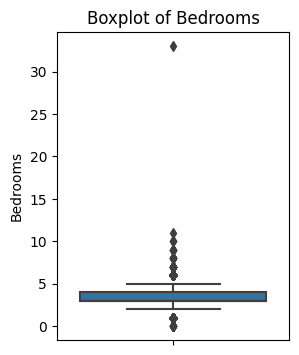

In [22]:
boxplot(df['bedrooms'], 'Bedrooms', figsize=(3, 4))

In [23]:
df_33_bedrooms = df[df['bedrooms'] == 33]
df_33_bedrooms

,id,date,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,...,grade,sqm_above,sqm_basement,yr_built,yr_renovated,zipcode,lat,long,sqm_living15,sqm_lot15
15870,2402100895,2014-06-25,640000,33,1.75,150.50,557.42,1.00,0,0,...,7,96.62,53.88,1947,0,98103,47.69,-122.33,123.56,436.64


The sale record for real estate object with id=2402100895 lists 33 bedrooms, which seems like a data entry error given the `sq_m_living` size (150.50 sq m). 3-4 bedrooms for this property size is within the data Interquartile Range (IQR). We will update the number of bedrooms from 33 to 3.

In [24]:
df.loc[df['id'] == 2402100895, 'bedrooms'] = 3

##### bathrooms

Column `bathrooms` has 30 different values which seems odd. Below are all unique values:

In [25]:
l = sorted(df['bathrooms'].unique()); print(l)

[0.0, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0]


An example of an object (id=9175600025) with 6.75 bathrooms:

In [26]:
df_qbathrooms = df[df['id'] == 9175600025]
df_qbathrooms

,id,date,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,...,grade,sqm_above,sqm_basement,yr_built,yr_renovated,zipcode,lat,long,sqm_living15,sqm_lot15
4024,9175600025,2014-10-07,800000,7,6.75,694.91,3870.71,2.00,0,2,...,11,471.95,222.97,1953,0,98166,47.46,-122.37,261.06,3083.45


0.5 accounts for a room with a toilet but no shower. To simplify, we will create a new column `toilet` with boolean values, True when bathrooms is > 0.5:

In [27]:
df['toilet'] = df['bathrooms'] > 0.5

Reordering columns:

In [28]:
new_column_order = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'toilet', 'sqm_living', 'sqm_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqm_above', 'sqm_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqm_living15', 'sqm_lot15']
df = df.loc[:, new_column_order]

Rounding `bathrooms` decimal values to the nearest integer:

In [29]:
df['bathrooms'] = df['bathrooms'].apply(lambda x: round(x))

An example of the same object (id=9175600025) after rounding down to the nearest integer:

In [30]:
df_qbathrooms = df[df['id'] == 9175600025]
df_qbathrooms

,id,date,price,bedrooms,bathrooms,toilet,sqm_living,sqm_lot,floors,waterfront,...,grade,sqm_above,sqm_basement,yr_built,yr_renovated,zipcode,lat,long,sqm_living15,sqm_lot15
4024,9175600025,2014-10-07,800000,7,7,True,694.91,3870.71,2.00,0,...,11,471.95,222.97,1953,0,98166,47.46,-122.37,261.06,3083.45


Now we have cleaned dataset with only integer values representing the number of bathrooms and a new column representing if an object has a toilet.

##### waterfront

Changing `waterfront` variable values to boolean:

In [31]:
df["waterfront"] = df["waterfront"].replace({
    1 : True, 
    0 : False
    })

##### yr_renovated

Changing `yr_renovated` 0 values to Null:

In [32]:
df['yr_renovated'] = df['yr_renovated'].replace({
    0 : np.nan
    })

Creating a new column `renovated` with boolean values:

In [33]:
df['renovated'] = df['yr_renovated'].notnull()

Reordering columns:

In [34]:
new_column_order = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'toilet', 'sqm_living', 'sqm_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqm_above', 'sqm_basement', 'yr_built', 'renovated', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqm_living15', 'sqm_lot15']
df = df.loc[:, new_column_order]

##### zipcode

Calculating unique `zipcode` values:

In [35]:
print('Number of unique zipcodes in the dataframe:', len(df.zipcode.unique()))

Number of unique zipcodes in the dataframe: 70


There are 70 unique zipcode values. To group them to larger groups, we are importing the table of zipcodes in King County, WA, and their Primary Cities:

In [36]:
zipcodes_df = pd.read_csv('data/zipcodes_King_County_WA.csv', delimiter=';')
zipcodes_df.head()

,ZIP,% of County Population,Type,Primary City
0,98001,0.02,Standard,Auburn
1,98002,0.02,Standard,Auburn
2,98092,0.02,Standard,Auburn
3,98224,0.00,PO Box,Baring
4,98004,0.01,Standard,Bellevue


Adding additional column `city` to the `df`:

In [37]:
zip_city_mapping = dict(zip(zipcodes_df['ZIP'], zipcodes_df['Primary City']))
df['city'] = df['zipcode'].map(zip_city_mapping)
print('Unique cities in the dataset:', len(df.city.unique()))

Unique cities in the dataset: 24


Reordering columns:

In [38]:
new_column_order = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'toilet', 'sqm_living', 'sqm_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqm_above', 'sqm_basement', 'yr_built', 'renovated', 'yr_renovated', 'zipcode', 'city', 'lat', 'long', 'sqm_living15', 'sqm_lot15']
df = df.loc[:, new_column_order]

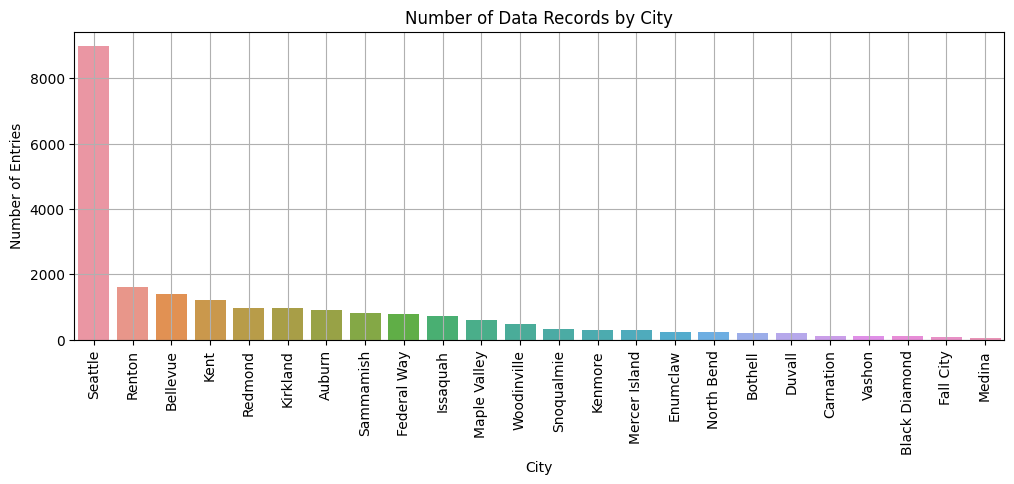

In [39]:
city_counts = df['city'].value_counts()
barplot(city_counts, 'Number of Data Records by City', 'City', 'Number of Entries', figsize=(12, 4), xticksrotation=90)

##### id - Deduplication:

Looking for duplicates by `id` column

In [40]:
duplicates = df[df.duplicated(['id'], keep=False)]
print('Lines with duplicating ids: ', len(duplicates))

Lines with duplicating ids:  353


Testing if all duplicates share the same features. Creating deduplication key in the df with all row elements except for `price` and `date`:

In [41]:
# Creating deduplication_key
columns_to_include = ['id', 'bedrooms', 'bathrooms', 'sqm_living', 'sqm_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqm_above', 'sqm_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqm_living15', 'sqm_lot15']
df['deduplication_key'] = df[columns_to_include].apply(lambda row: '_'.join(map(str, row)), axis=1)
# Finding duplicates by the deduplication_key
duplicates = df[df.duplicated(subset='deduplication_key', keep=False)]
print('Lines with duplicating ids where all features remain the same: ', len(duplicates))

Lines with duplicating ids where all features remain the same:  353


All features remain the same except for price and date. This means the object was sold more than once with all same features but different price.

Creating deduplicated **df_latest** where latest date values are left in the df:

In [42]:
df_latest = df.sort_values(by='date', ascending=True)
df_latest = df_latest.drop_duplicates('id', keep='last')
del df_latest['deduplication_key']
del df['deduplication_key']

One duplicate (id=6021501535) example in original **df**:

In [43]:
example_id = df[df['id'] == 6021501535]
example_id

,id,date,price,bedrooms,bathrooms,toilet,sqm_living,sqm_lot,floors,waterfront,...,sqm_basement,yr_built,renovated,yr_renovated,zipcode,city,lat,long,sqm_living15,sqm_lot15
93,6021501535,2014-07-25,430000,3,2,True,146.79,464.52,1.00,False,...,26.94,1939,False,NaN,98117,Seattle,47.69,-122.39,145.86,418.06
94,6021501535,2014-12-23,700000,3,2,True,146.79,464.52,1.00,False,...,26.94,1939,False,NaN,98117,Seattle,47.69,-122.39,145.86,418.06


The same duplicate (id=6021501535) example in **df_latest**:

In [44]:
example_id = df_latest[df_latest['id'] == 6021501535]
example_id

,id,date,price,bedrooms,bathrooms,toilet,sqm_living,sqm_lot,floors,waterfront,...,sqm_basement,yr_built,renovated,yr_renovated,zipcode,city,lat,long,sqm_living15,sqm_lot15
94,6021501535,2014-12-23,700000,3,2,True,146.79,464.52,1.00,False,...,26.94,1939,False,NaN,98117,Seattle,47.69,-122.39,145.86,418.06


In [45]:
print('Number of rows in df: ', df.shape[0])
print('Number of rows in df_latest: ', df_latest.shape[0])

Number of rows in df:  21613
Number of rows in df_latest:  21436


After deduplication dataframe should have 21436 remaining rows.

No feature other than the price changes from one sale to the next, and one year period is too short for the real estate value to increase because of capital appreciation. Taking the average price of sales of the same object would skew the price data from slightly platykurtic distribution (kurtosis value (-0.01)) to sligthly leptokurtic (kurtosis value (0.09)) and further from Gaussian distribution (The analysis has been done but not included into this notebook).  
**We have no justification for a price change using the data provided, so we are going to keep the latest sale data.**

In [46]:
df = df_latest.copy()

Since now the dataframe has only unique IDs:

In [47]:
num_unique_ids = df['id'].nunique()
num_of_lines = len(df)
print('Number of lines in all df:', num_of_lines)
print('Number of unique IDs in df:', num_unique_ids)
print('Dataframe contains only unique IDs: ', (num_unique_ids==num_of_lines))

Number of lines in all df: 21436
Number of unique IDs in df: 21436
Dataframe contains only unique IDs:  True


ID column can now be removed:

In [48]:
del df['id']

#### Data after the cleaning

Data shape:

In [49]:
print(f'Dataframe has {df.shape[0]} lines and {df.shape[1]} columns.')

Dataframe has 21436 lines and 23 columns.


All columns:

In [50]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'toilet', 'sqm_living',
       'sqm_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqm_above', 'sqm_basement', 'yr_built', 'renovated', 'yr_renovated',
       'zipcode', 'city', 'lat', 'long', 'sqm_living15', 'sqm_lot15'],
      dtype='object')

Variables that have been added:  
- `renovated`  
- `toilet`
- `city`

One column removed:  
- `id`

Existing data types:

In [51]:
df.dtypes.value_counts()

float64           10
int64              7
bool               3
datetime64[ns]     1
int32              1
object             1
Name: count, dtype: int64

Number of unique values in each column:

In [52]:
df.nunique()

date             372
price           3997
bedrooms          12
bathrooms          9
toilet             2
sqm_living      1038
sqm_lot         9782
floors             6
waterfront         2
view               5
condition          5
grade             12
sqm_above        946
sqm_basement     306
yr_built         116
renovated          2
yr_renovated      69
zipcode           70
city              24
lat             5034
long             752
sqm_living15     777
sqm_lot15       8689
dtype: int64

In [53]:
df.describe(include=['bool', 'object'])

,toilet,waterfront,renovated,city
count,21436,21436,21436,21436
unique,2,2,2,24
top,True,False,False,Seattle
freq,21422,21273,20526,8889


In [54]:
df.describe(include='int64')

,bedrooms,bathrooms,view,condition,grade,yr_built,zipcode
count,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00
mean,3.37,2.06,0.24,3.41,7.66,1971.10,98077.86
std,0.91,0.76,0.77,0.65,1.17,29.39,53.47
min,0.00,0.00,0.00,1.00,1.00,1900.00,98001.00
25%,3.00,2.00,0.00,3.00,7.00,1952.00,98033.00
50%,3.00,2.00,0.00,3.00,7.00,1975.00,98065.00
75%,4.00,2.00,0.00,4.00,8.00,1997.00,98117.00
max,11.00,8.00,4.00,5.00,13.00,2015.00,98199.00


In [55]:
df.describe(include='float64')

,sqm_living,sqm_lot,floors,sqm_above,sqm_basement,yr_renovated,lat,long,sqm_living15,sqm_lot15
count,21436.00,21436.00,21436.00,21436.00,21436.00,910.00,21436.00,21436.00,21436.00,21436.00
mean,193.49,1406.15,1.50,166.39,27.10,1995.90,47.56,-122.21,184.72,1187.85
std,85.39,3859.06,0.54,77.02,41.14,15.50,0.14,0.14,63.70,2543.26
min,26.94,48.31,1.00,26.94,0.00,1934.00,47.16,-122.52,37.07,60.48
25%,132.85,468.23,1.00,111.48,0.00,1987.00,47.47,-122.33,138.43,473.81
50%,178.37,707.36,1.50,144.93,0.00,2000.00,47.57,-122.23,170.94,707.92
75%,236.90,993.71,2.00,206.24,52.03,2007.00,47.68,-122.12,220.18,937.13
max,1257.91,153416.21,3.50,874.22,447.79,2015.00,47.78,-121.31,576.93,80937.09


**Quantitative variables**: sqm_living, sqm_above, sqm_basement, sqm_lot, sqm_living15, sqm_lot15, floors, yr_renovated, bedrooms, bathrooms, yr_built  
  
**Categorical variables**: view, condition, grade, zipcode, city, renovated, toilet, waterfront

#### Missing values

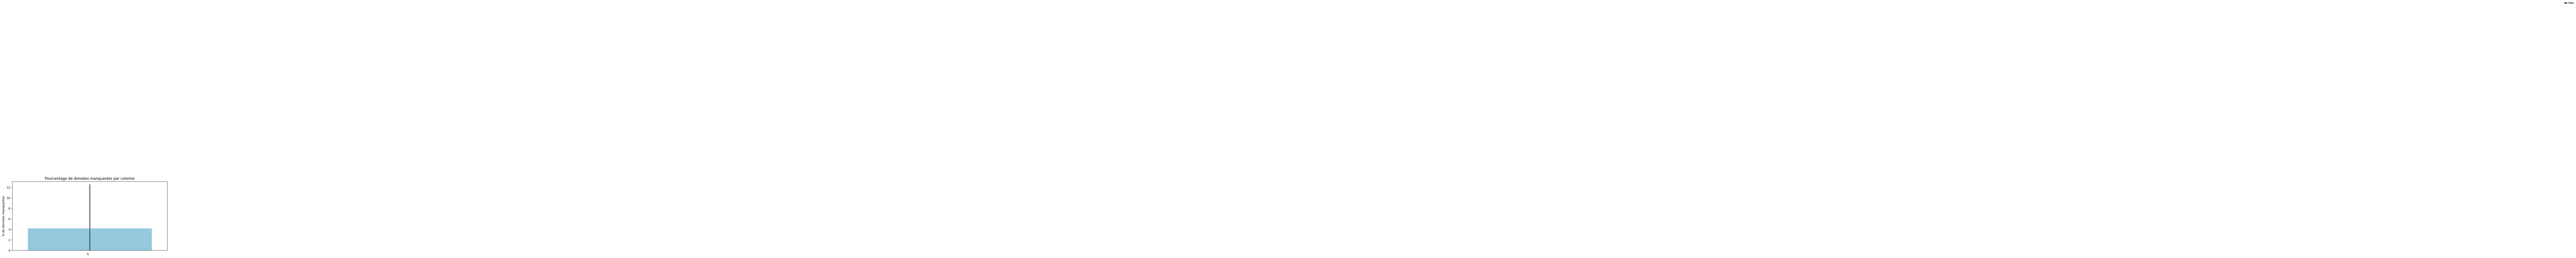

In [56]:
# Calculer le pourcentage de données manquantes par colonne
pourcentage_manquant_par_colonne = df.copy()
pourcentage_manquant_par_colonne = pourcentage_manquant_par_colonne.isnull().sum() / len(df) * 100

# Créer le graphique à barres
plt.figure(figsize=(8, 4))
sns.barplot(pourcentage_manquant_par_colonne, color='skyblue')
plt.title('Pourcentage de données manquantes par colonne')
plt.ylabel("% de données manquantes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Ajouter les valeurs non nulles au-dessus de chaque barre
for i, v in enumerate(pourcentage_manquant_par_colonne.values):
    if v != 0:  # Vérifier si la valeur est non nulle
        plt.text(i, (v / 2) - 1, f"{round(v, 2)}%", ha='center', va='bottom', fontsize=8, fontweight='bold')
plt.show()

#### Univariate analysis

##### Quantitative variables

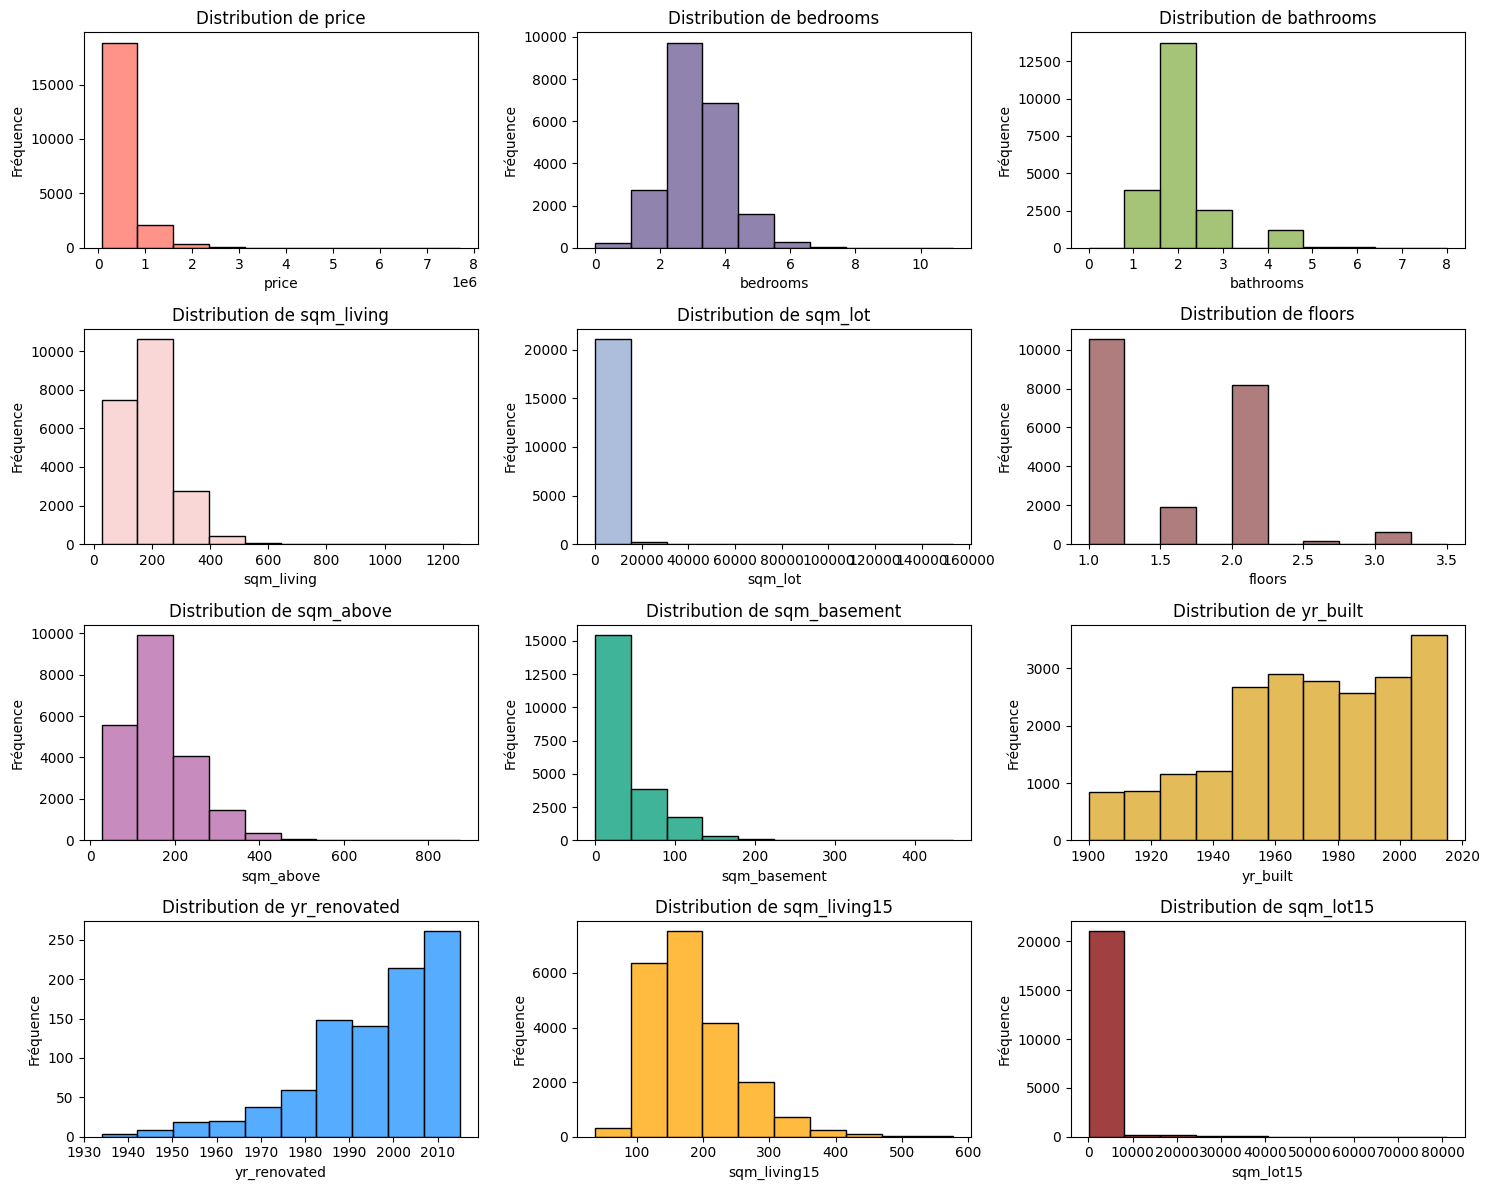

In [57]:
# Création d'une figure globale avec des sous-graphiques
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

# Boucle pour générer les graphiques pour chaque variable
for i, (variable, color) in enumerate(zip(variables_quantitatives, colors_quantitative)):
    
    # Identifier les sous-graphiques
    row = i // 3  # Calcul de la ligne
    col = i % 3   # Calcul de la colonne

    # Histogramme des données brutes
    sns.histplot(df[variable], bins=10, color=color, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution de {variable}')
    axes[row, col].set_ylabel('Fréquence')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

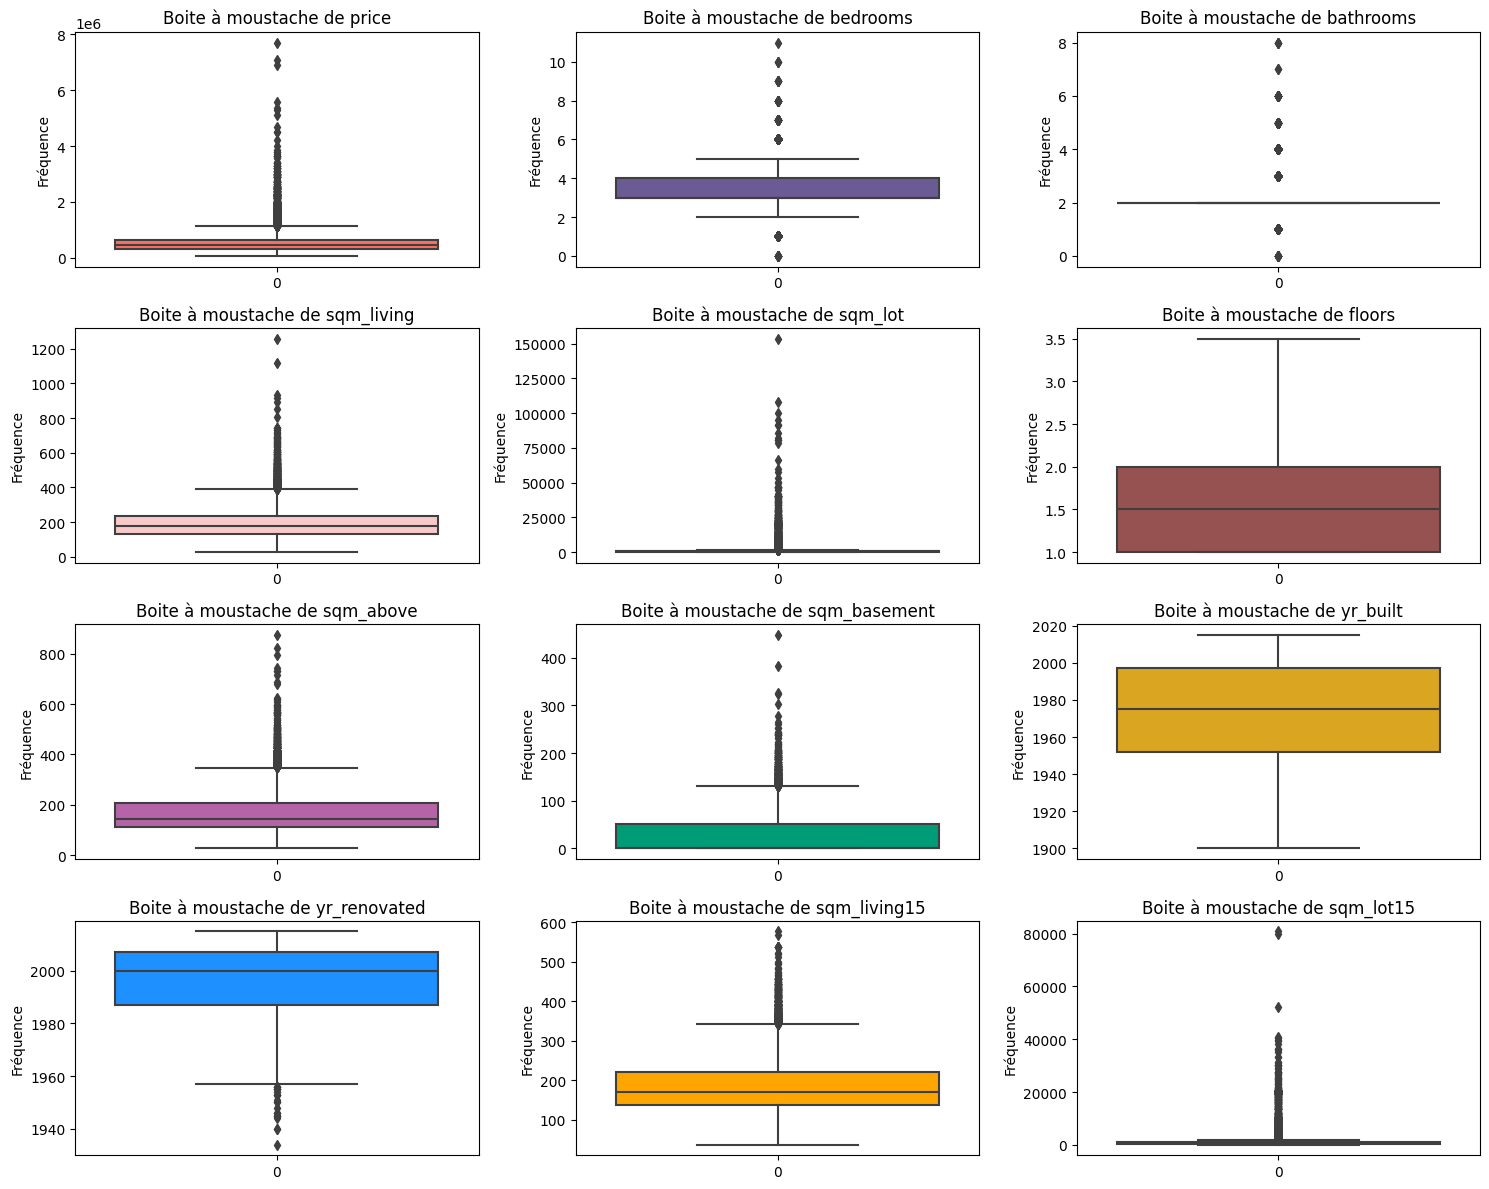

In [58]:
# Création d'une figure globale avec des sous-graphiques
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

# Boucle pour générer les graphiques pour chaque variable
for i, (variable, color) in enumerate(zip(variables_quantitatives, colors_quantitative)):
    
    # Identifier les sous-graphiques
    row = i // 3  # Calcul de la ligne
    col = i % 3   # Calcul de la colonne

    # Boîte à moustaches
    sns.boxplot(df[variable], boxprops=dict(facecolor=color), ax=axes[row, col])
    axes[row, col].set_title(f'Boite à moustache de {variable}')
    axes[row, col].set_ylabel('Fréquence')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

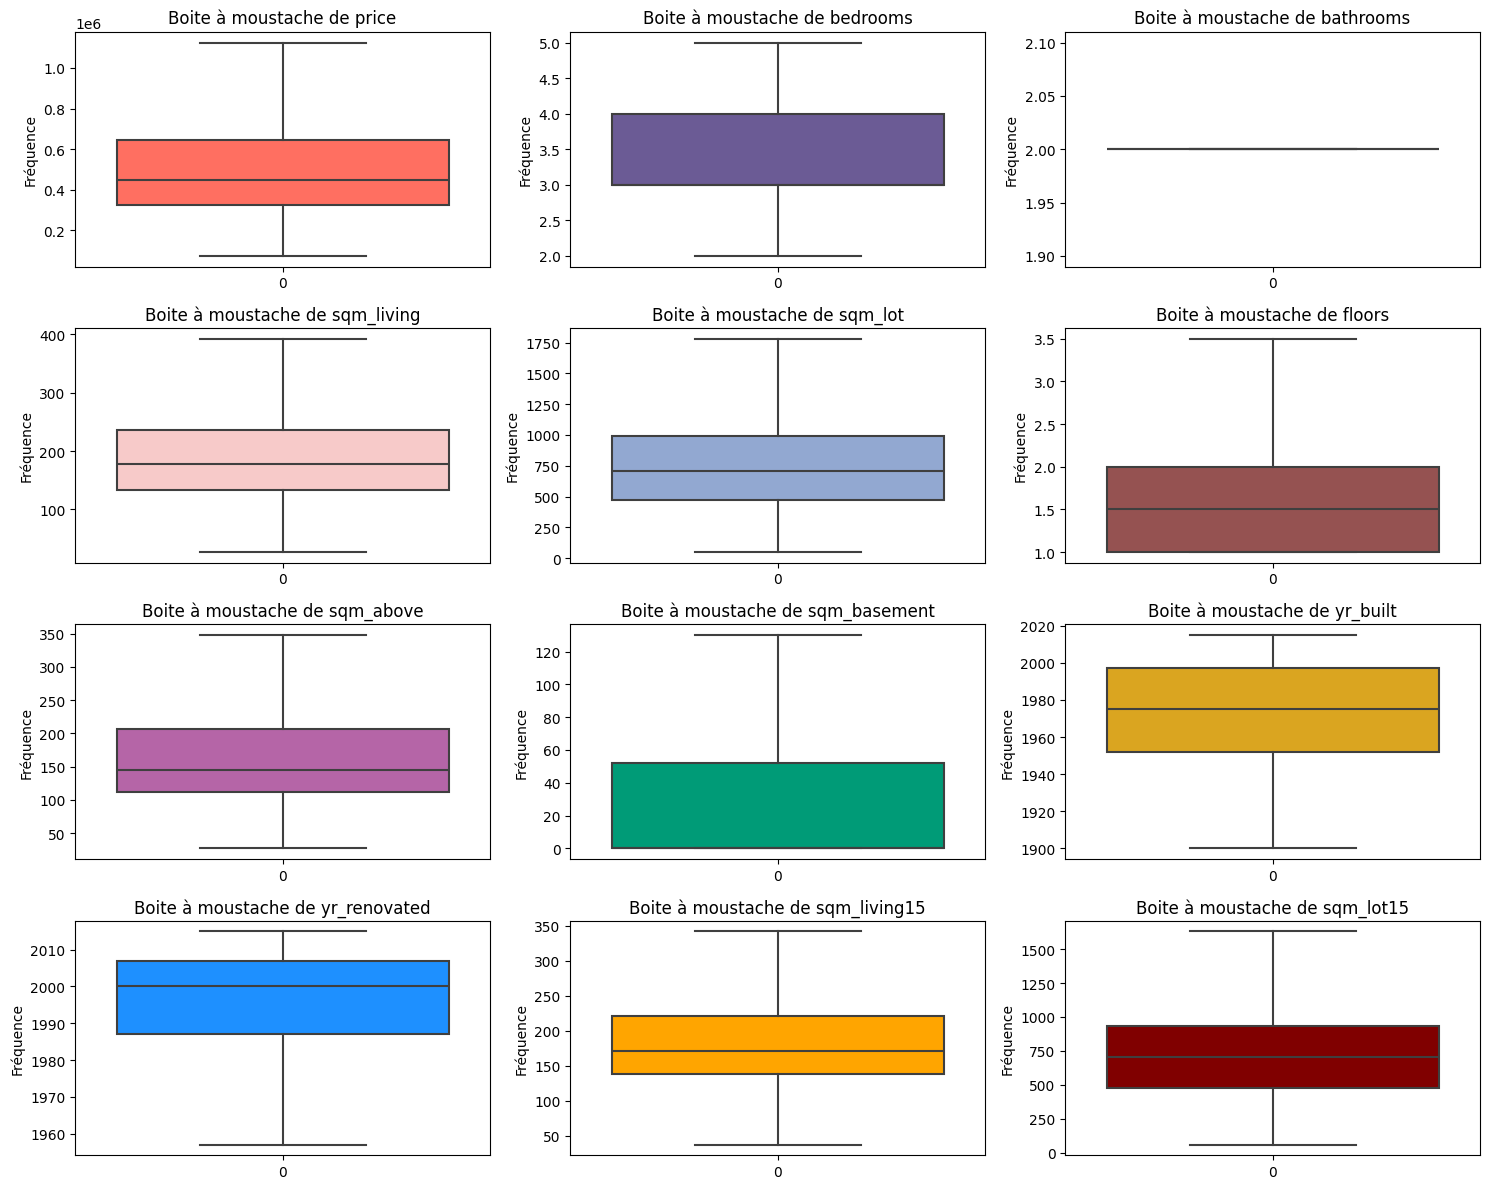

In [59]:
# Création d'une figure globale avec des sous-graphiques
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

# Boucle pour générer les graphiques pour chaque variable
for i, (variable, color) in enumerate(zip(variables_quantitatives, colors_quantitative)):
    
    # Identifier les sous-graphiques
    row = i // 3  # Calcul de la ligne
    col = i % 3   # Calcul de la colonne

    # Boîte à moustaches
    sns.boxplot(df[variable], boxprops=dict(facecolor=color), ax=axes[row, col], showfliers=False)
    axes[row, col].set_title(f'Boite à moustache de {variable}')
    axes[row, col].set_ylabel('Fréquence')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

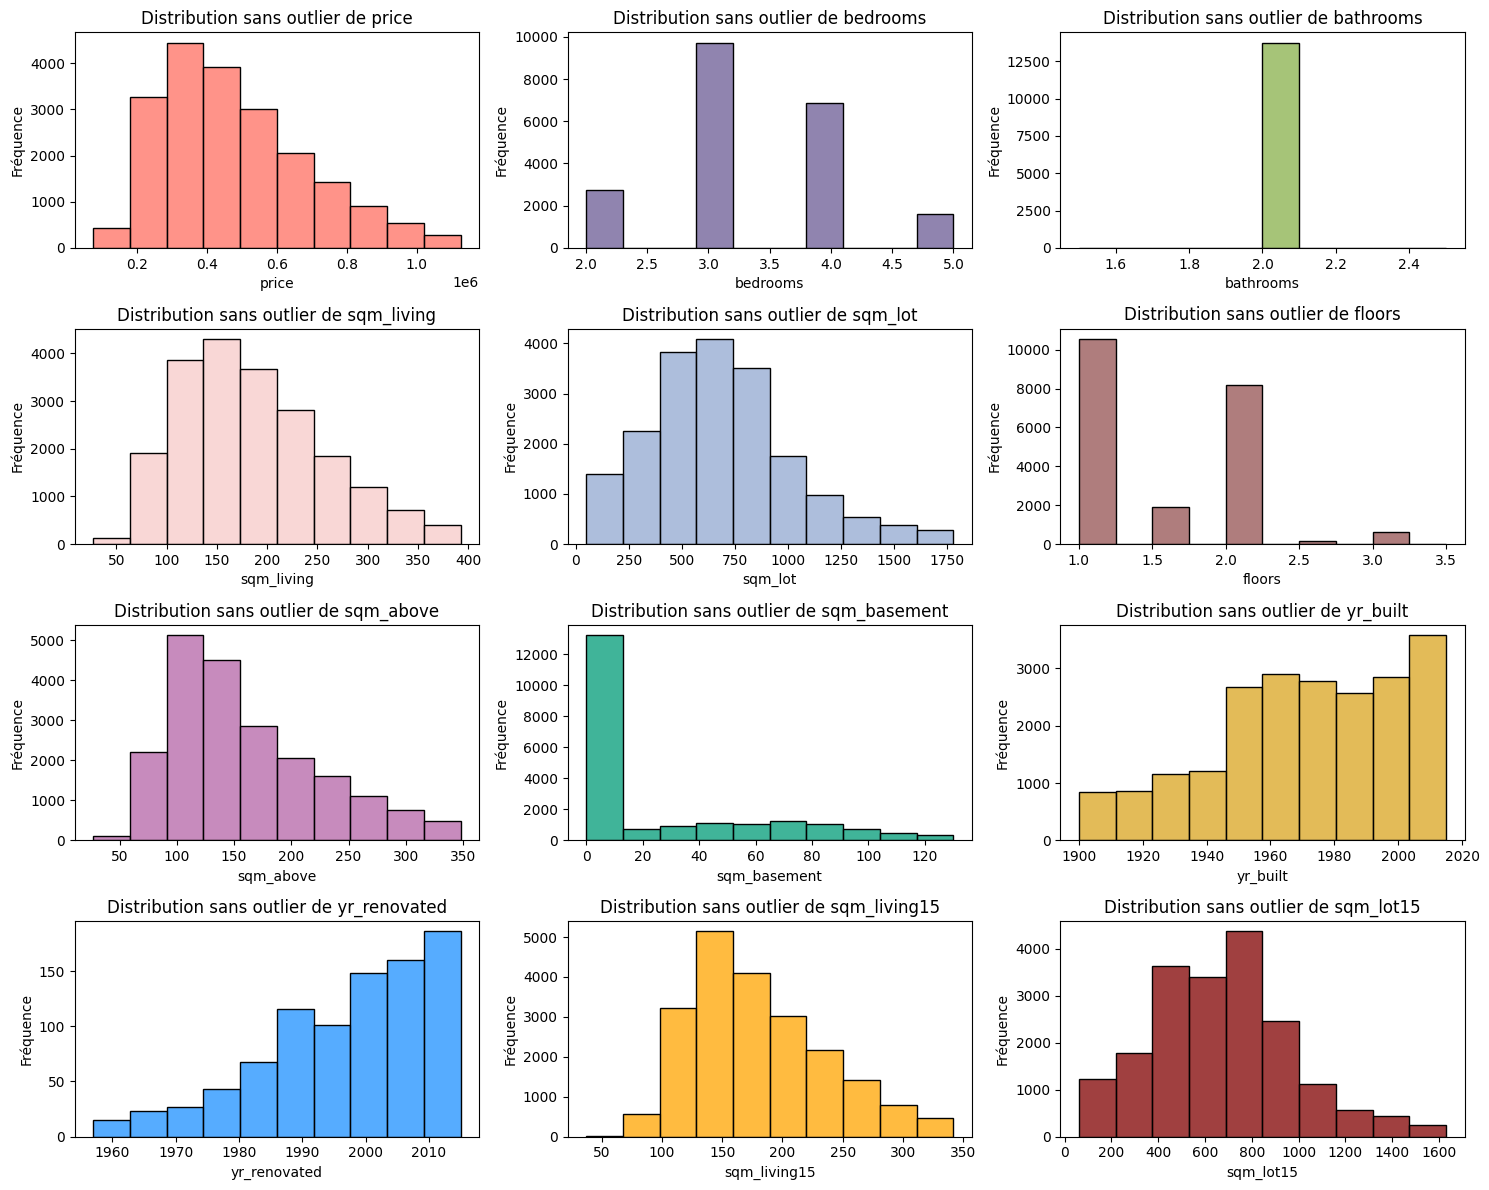

In [60]:
# Création d'une figure globale avec des sous-graphiques
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

# Boucle pour générer les graphiques pour chaque variable
for i, (variable, color) in enumerate(zip(variables_quantitatives, colors_quantitative)):
    
    # Identifier les sous-graphiques
    row = i // 3  # Calcul de la ligne
    col = i % 3   # Calcul de la colonne

    # Histogramme des données filtrées (sans valeurs aberrantes)
    lower_bound = boxplot_whiskers(df[variable])[0]
    upper_bound = boxplot_whiskers(df[variable])[1]
    filtered_data = df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]
    
    sns.histplot(filtered_data[variable], bins=10, color=color, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution sans outlier de {variable}')
    axes[row, col].set_ylabel('Fréquence')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

##### Categorical variables

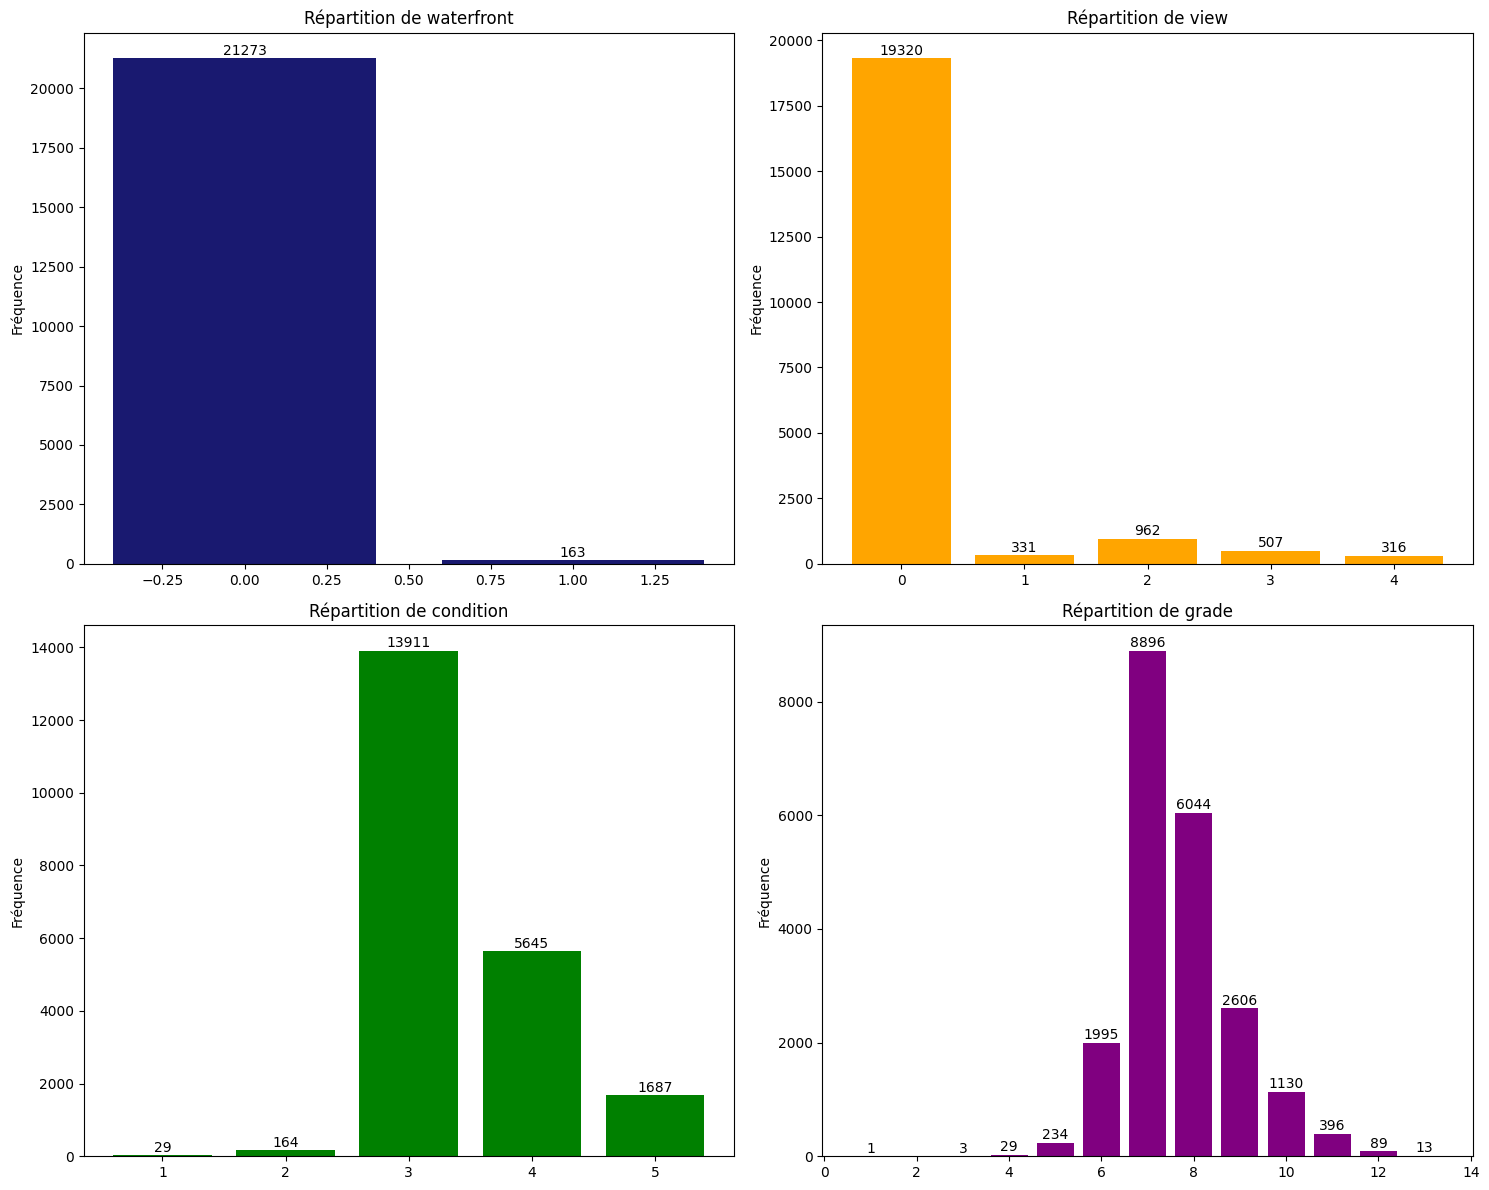

In [61]:
# Création d'une figure globale avec des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Boucle pour générer les graphiques pour chaque variable
for i, (variable, color) in enumerate(zip(variables_qualitatives, colors_qualitative)):
    # Compter les occurrences de chaque catégorie
    counts = df[variable].value_counts()
    
    # Identifier les sous-graphiques
    row = i // 2  # Calcul de la ligne
    col = i % 2   # Calcul de la colonne

    # Diagramme en barres
    ax = axes[row, col]
    ax.bar(counts.index, counts.values, color=color)
    ax.set_title(f'Répartition de {variable}')
    ax.set_ylabel('Fréquence')

    # Ajout des valeurs au-dessus des barres
    for j, (view, count) in enumerate(counts.items()):
        ax.text(view, count + 10, str(count), ha='center', va='bottom')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

In [62]:
# sns.pairplot(data=filtered_data, diag_kind="hist")

#### Multivariate analysis | Correlation & Association tests

##### sqm_living, sqm_lot

Creating a `df_temp` without sqm_living outliers (iterative approach on outliers removal):

In [63]:
df_temp = df.copy()
df_temp = df_temp[(df_temp['sqm_living'] <= boxplot_whiskers_iterative_outliers_removal(df_temp, 'sqm_living')[1])]

Box plot of bedrooms by square meters living group:

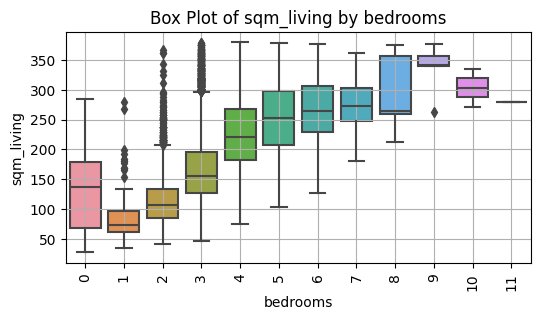

In [64]:
boxplot_categories(df_temp, 'bedrooms', 'sqm_living', (6, 3), 90, False, 'Box Plot of sqm_living by bedrooms')

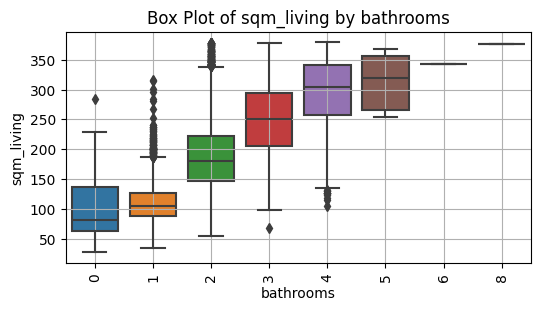

In [65]:
boxplot_categories(df_temp, 'bathrooms', 'sqm_living', (6, 3), 90, False, 'Box Plot of sqm_living by bathrooms')

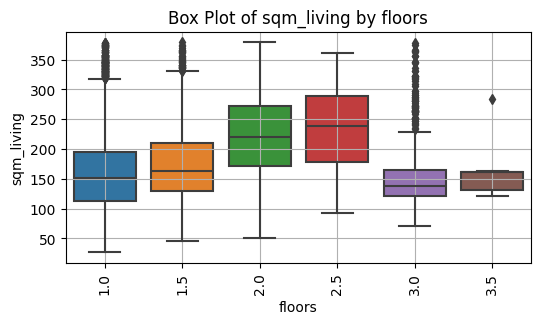

In [66]:
boxplot_categories(df_temp, 'floors', 'sqm_living', (6, 3), 90, False, 'Box Plot of sqm_living by floors')

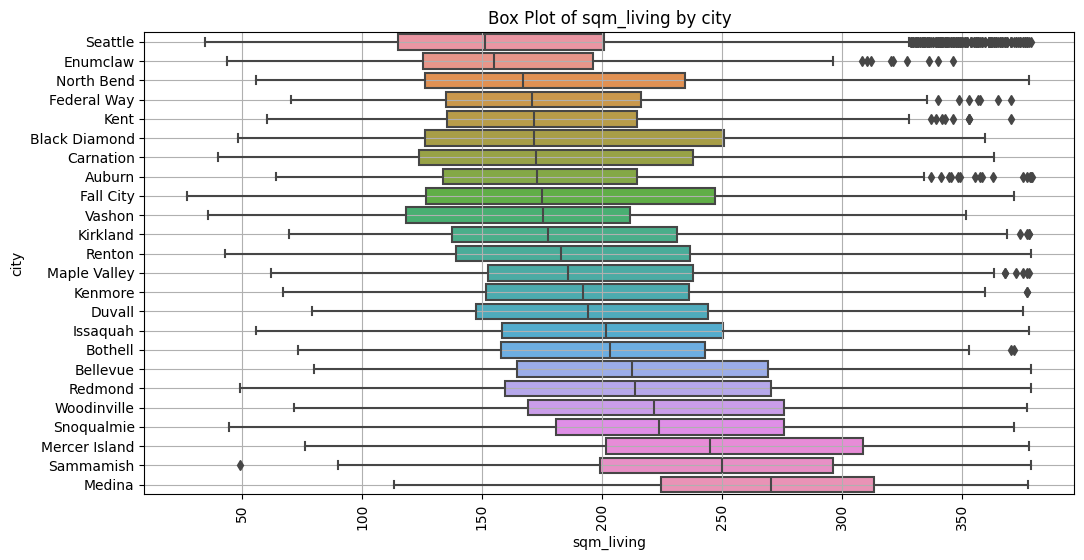

In [67]:
boxplot_categories(df_temp, 'sqm_living', 'city', (12, 6), 90, True, 'Box Plot of sqm_living by city')

Updating a `df_temp` by removing sqm_lot outliers (iterative approach on outliers removal):

In [68]:
whiskers = boxplot_whiskers_iterative_outliers_removal(df, 'sqm_lot')
df_temp = df_temp[(df_temp['sqm_lot'] >= whiskers[0]) & (df_temp['sqm_lot'] <= whiskers[1])]

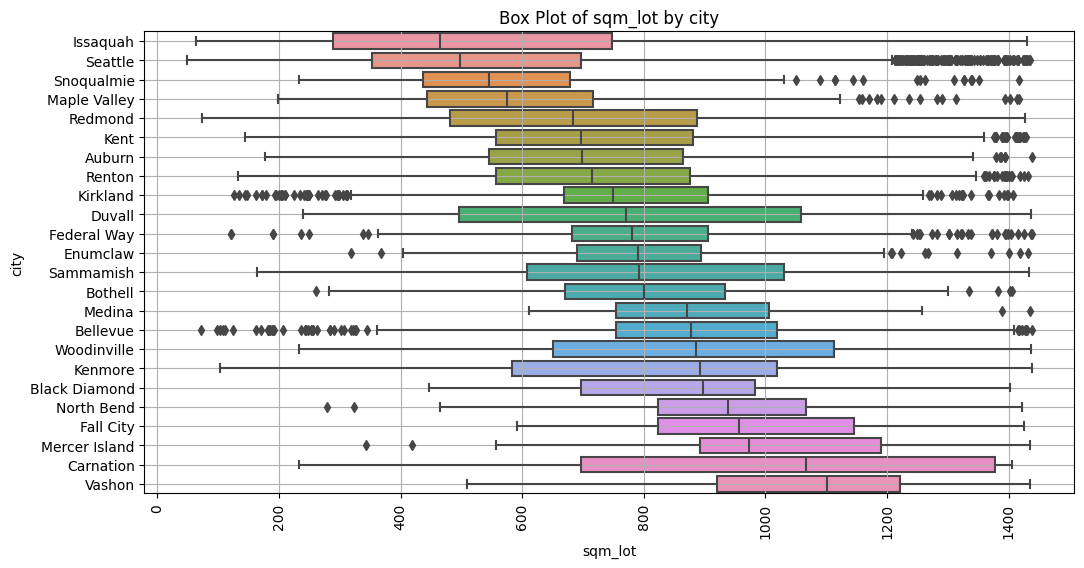

In [69]:
boxplot_categories(df_temp, 'sqm_lot', 'city', (12, 6), 90, True, 'Box Plot of sqm_lot by city')

The list of cities ordered by median by `sqm_living` completely change compared to order by `sqm_lot`.

##### price

Updating a `df_temp` by removing price outliers (iterative approach on outliers removal):

In [70]:
whiskers = boxplot_whiskers_iterative_outliers_removal(df_temp, 'price')
df_temp = df_temp[(df_temp['price'] >= whiskers[0]) & (df_temp['price'] <= whiskers[1])]

Updating a `df_temp` with a new `sqm_living_group` column that groups `sqm_living` data by Sq m living data distribution, 12 histogram bins:

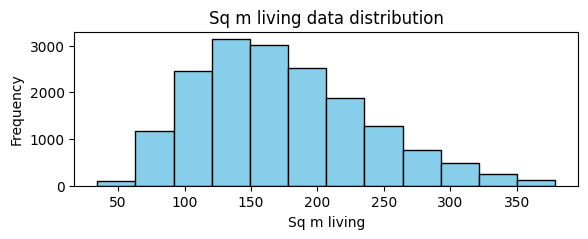

Bin 1:  starts at 34.37 ends at 63.09
Bin 2:  starts at 63.09 ends at 91.81
Bin 3:  starts at 91.81 ends at 120.53
Bin 4:  starts at 120.53 ends at 149.25
Bin 5:  starts at 149.25 ends at 177.97
Bin 6:  starts at 177.97 ends at 206.69
Bin 7:  starts at 206.69 ends at 235.41
Bin 8:  starts at 235.41 ends at 264.13
Bin 9:  starts at 264.13 ends at 292.85
Bin 10:  starts at 292.85 ends at 321.57
Bin 11:  starts at 321.57 ends at 350.29
Bin 12:  starts at 350.29 ends at 379.01


In [71]:
df_temp = create_column_histogram_bin_number(df_temp, 'sqm_living', 12, 'sqm_living_group')
no_of_bins = 12
histogram(df_temp['sqm_living'], label='Sq m living', bins=no_of_bins, figsize=(6.5, 2))
hist_bin_values = histogram_bins_values(df_temp['sqm_living'], no_of_bins, print_flag=True)

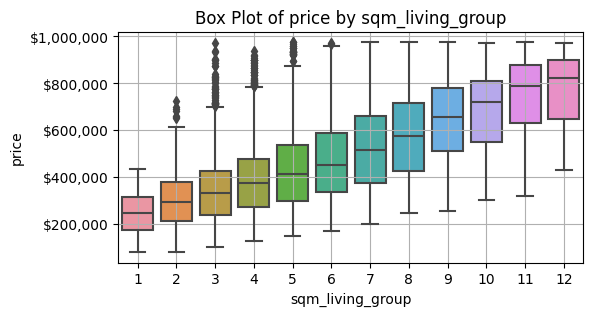

In [72]:
boxplot_categories(df_temp, 'sqm_living_group', 'price', (6, 3))

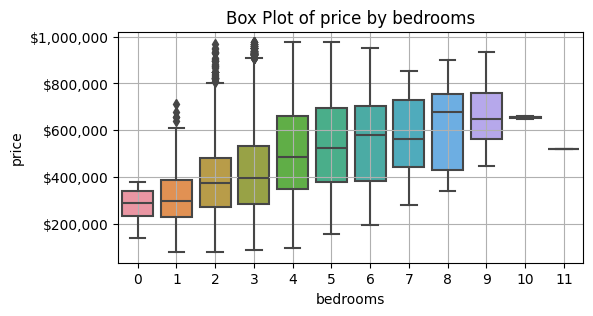

In [73]:
boxplot_categories(df_temp, 'bedrooms', 'price', (6, 3))

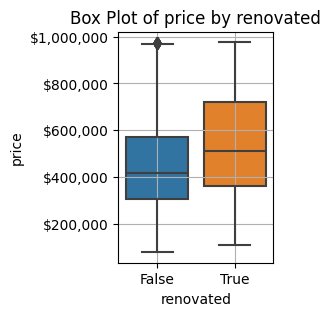

In [74]:
boxplot_categories(df_temp, 'renovated', 'price', (2, 3))

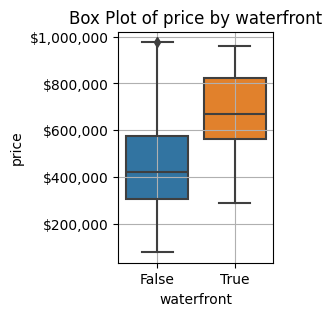

In [75]:
boxplot_categories(df_temp, 'waterfront', 'price', (2, 3))

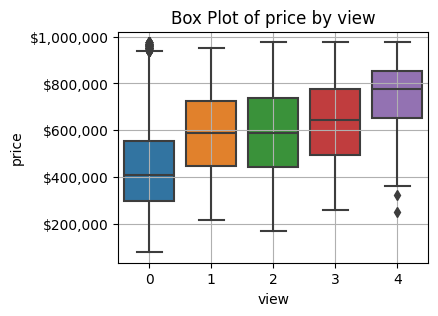

In [76]:
boxplot_categories(df_temp, 'view', 'price', (4, 3))

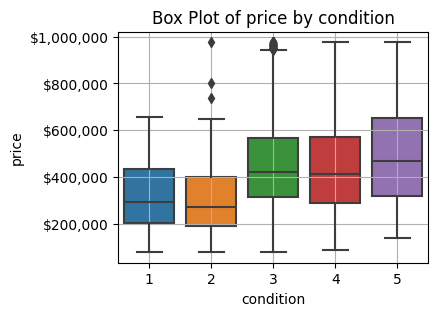

In [77]:
boxplot_categories(df_temp, 'condition', 'price', (4, 3))

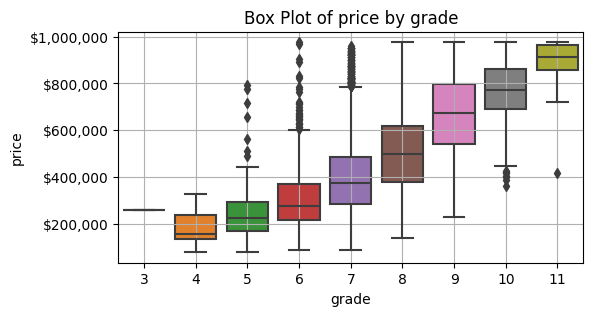

In [78]:
boxplot_categories(df_temp, 'grade', 'price', (6, 3))

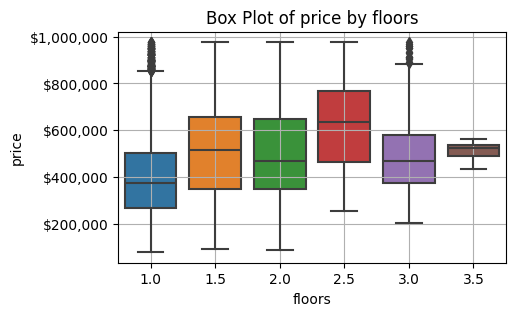

In [79]:
boxplot_categories(df_temp, 'floors', 'price', (5, 3))

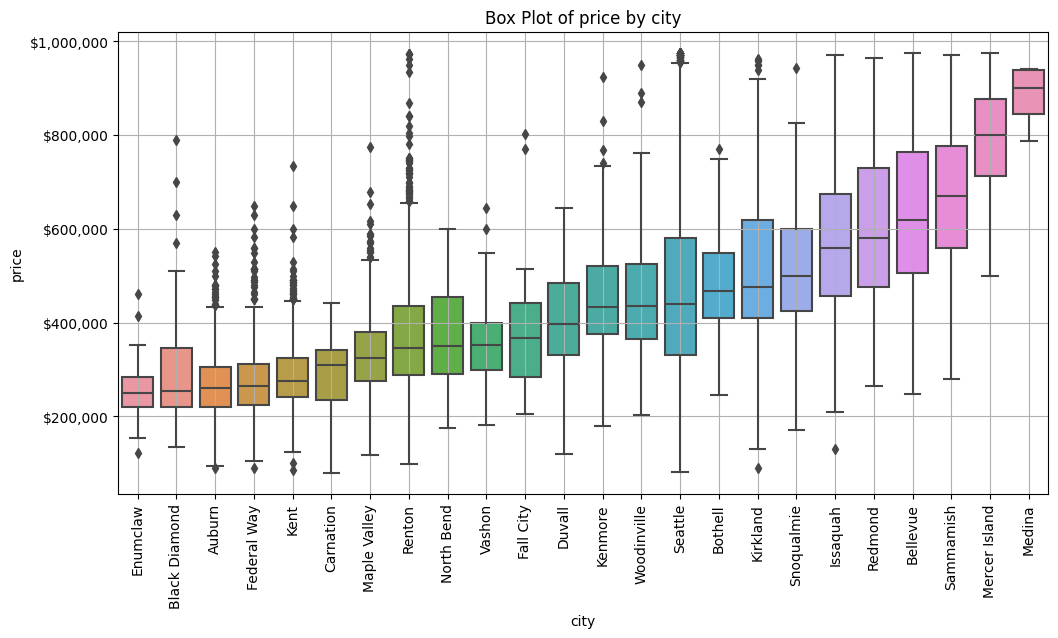

In [80]:
boxplot_categories(df_temp, 'city', 'price', (12, 6), 90, order_by_median_flag=True)

In [81]:
color_scale = ['#00FF00', '#FFFF00', '#FF0000']  # Green, Yellow, Red
fig = px.scatter_mapbox(df_temp, lat='lat', lon='long', color='price',
                        color_continuous_scale=color_scale,
                        hover_data=['price', 'city', 'sqm_above'], 
                        zoom=10)
fig.update_layout(mapbox_style="open-street-map",
                  coloraxis_colorbar=dict(title="Price"),
                  title="Districts by Price (Cheapest to Most Expensive)")
fig.show()

#### Exporting the cleaned dataframe to CSV